In [ ]:
import os
import sys
from collections import namedtuple
import math
import numpy as np
npa = np.array
import torch
import torchvision
from PIL import Image
import pandas as pd


from torch.utils.data import Dataset, DataLoader
from spacetorch.datasets import DatasetRegistry

from utils import *
import foolbox as fb
from autoattack import AutoAttack
import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import ImageGrid

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

from utils import get_model
from load_model import *
import argparse
from torchvision.utils import save_image

# Robustness

In [ ]:
model = load_model(pool_type='gaussian', kap_kernelsize=0.23, continuous=True, local_conv=False, expname='gaussian_0.23_continuous_prog_t', epoch=110, sel_range=20)

imagenet = get_imagenet_val_loader(
      batch_size=10, data_path="/kernel_avpool/data/datasets/imagenet/val", norm=False)


fmodel = fb.PyTorchModel(model, bounds=(0, 1), device=device)# preprocessing=preprocessing)


advs, success = [], []
for images, labels in [next(iter(imagenet))]:
    if len(success) > 20:
        break
    # attack = fb.attacks.LinfPGD(steps=20, abs_stepsize=1/255.)
    attack = fb.attacks.L2PGD(steps=100, abs_stepsize=4/255.)
    _, current_advs, current_success = attack(fmodel, images.to(device), labels.to(device), epsilons=[0.1])#1. #0.1 has 10
    advs.append(current_advs)
    success.append(current_success)

adv_images = torch.cat([torch.stack(ad) for ad in advs], dim=1).cpu().numpy()
success = torch.cat(success, dim=-1)


attack_success = success.cpu().numpy()
print("Robustness", 100 * (1 - attack_success.mean(-1)))
print("Note this result is from a few of example and it is not reliable! Continue to the rest!")


In [ ]:
in_images, in_labels = [], []
for im, l in imagenet:
    if len(in_images) >= 100:
        break
    in_images.append(im)
    in_labels.append(l)
in_images = torch.cat(in_images, dim=0)
in_labels = torch.cat(in_labels, dim=0)


# AutoAttack
# apgd-ce, apgd-t, fab-t, square
epsilon = 1
adversary = AutoAttack(model, norm='L2', eps=epsilon, version='standard')  # standard, rand
#adversary.attacks_to_run = ['square']
# adversary.attacks_to_run = []
# adversary.square.n_restarts = 5
# adversary.square.n_queries = 10000
x_adv, y_adv = adversary.run_standard_evaluation(in_images[:500], in_labels[:500], bs=25, return_labels=True)


#ED

In [ ]:
import numpy as np
from numpy.random import default_rng

from sklearn.decomposition import PCA




def effective_dim(eigvals: np.ndarray) -> float:
    squared_sum = np.sum(eigvals) ** 2
    sum_of_squares = np.sum(eigvals**2)
    effective_dim = squared_sum / sum_of_squares
    return effective_dim


def compute_eigvals(features: np.ndarray) -> np.ndarray:
    pca = PCA().fit(features)
    return pca.explained_variance_

In [ ]:
import pickle

with open('IT_features_r_0.pkl', 'rb') as f:
    c1 = pickle.load(f)

with open('IT_features_r_3.pkl', 'rb') as f:
    c3 = pickle.load(f)

with open('IT_features_r_13.pkl', 'rb') as f:
    c13 = pickle.load(f)

In [ ]:
import pickle
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np



pca = PCA(n_components=10)
pca.fit(c1)
projections = pca.transform(c1)
print(np.sum(pca.explained_variance_ratio_))
pca.explained_variance_ratio_

0.9851333


array([0.8607244 , 0.07385299, 0.01804949, 0.01311532, 0.00481243,
       0.00426402, 0.00330286, 0.00292463, 0.00249737, 0.00158978],
      dtype=float32)

In [ ]:
effective_dim(compute_eigvals(c1))

1.338907142315041

# Manifold

In [ ]:
import pickle
with open('nsd_layer4_gaussian.pkl', 'rb') as f:
    IT_features = pickle.load(f) #(7901, 2116)

In [ ]:
IT_features = IT_features.swapaxes(0, 1)

IT_features = normalize(IT_features, axis=1)

In [ ]:
#from scipy.ndimage import gaussian_filter
#logits_over_time = gaussian_filter(logits_over_time, sigma=2)

from sklearn.decomposition import PCA
import numpy as np


pca = PCA(n_components=10)
#pca.fit(IT_features[:int(2116/4)])
#projections = pca.transform(IT_features[:int(2116/4)])

#pca.fit(IT_features[int(2116/4):2*int(2116/4)])
#projections = pca.transform(IT_features[int(2116/4):2*int(2116/4)])

#pca.fit(IT_features[2*int(2116/4):3*int(2116/4)])
#projections = pca.transform(IT_features[2*int(2116/4):3*int(2116/4)])

#pca.fit(IT_features[3*int(2116/4):4*int(2116/4)])
#projections = pca.transform(3*IT_features[3*int(2116/4):4*int(2116/4)])


pca.fit(IT_features)
projections = pca.transform(IT_features)

#pca.fit(IT_features)
#projections = pca.transform(IT_features)
print(np.sum(pca.explained_variance_ratio_))
pca.explained_variance_ratio_

0.49914


array([0.12842028, 0.08634777, 0.06396652, 0.04645707, 0.0425371 ,
       0.03218166, 0.03019578, 0.02439343, 0.02235178, 0.02228861],
      dtype=float32)

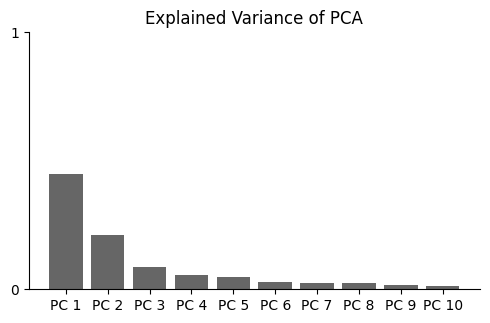

In [ ]:
fig = plt.figure(figsize=(5, 5*2/3))
gs = fig.add_gridspec(3, 1, width_ratios=[1])


ax7 = fig.add_subplot(gs[:3, 0])


PC=['PC 1', 'PC 2', 'PC 3', 'PC 4','PC 5','PC 6','PC 7','PC 8','PC 9', 'PC 10']

ax7.bar(x=[1, 2, 3, 4, 5, 6,7, 8, 9, 10], height = pca.explained_variance_ratio_, tick_label=PC, color = "k", alpha = 0.6)
ax7.set_title('Explained Variance of PCA')
ax7.set_ylim(0, 1)
ax7.set_yticks([0, 1])
ax7.spines[['right', 'top']].set_visible(False)

fig.tight_layout()

plt.savefig("pca_ev.pdf", format = 'pdf')

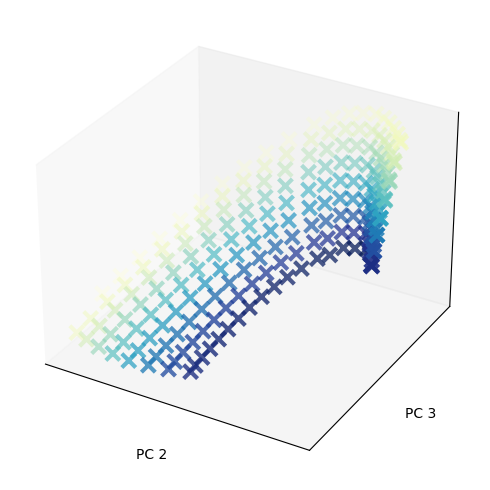

In [ ]:
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(3, 1, width_ratios=[1])#, height_ratios=[1, 2, 1])

ax6 = fig.add_subplot(gs[:3, 0], projection='3d')

#projections = projections[600:800, :]
x = np.arange(len(projections))

#ax6.plot(-projections[:, 1], projections[:,2],projections[:, 0], color="k", linewidth=3, alpha = 0.5, marker="x", markerfacecolor="#ccc")
ax6.scatter(-projections[:, 1], projections[:,2],projections[:, 0], c=x ,cmap="YlGnBu", linewidth=3, marker="x", s = 100)#, markerfacecolor="#ccc")

#ax6.scatter(-projections[:, 1][index], projections[:,2][index],projections[:, 0][index], color="r", linewidth=3, alpha = 0.5, marker="x")
#ax6.plot(-projections[:, 1][:100], projections[:,2][:100],projections[:, 0][:100], color="r", linewidth=3, alpha = 0.5, marker="x")

ax6.set_xlabel('PC 2')
ax6.set_ylabel('PC 3')
ax6.set_zlabel('PC 1')

ax6.view_init(elev=30)#, roll=15)

# Hide grid lines
ax6.grid(True)

# Hide axes ticks
ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_zticks([])

fig.tight_layout()
plt.savefig("pca.pdf", format = 'pdf')


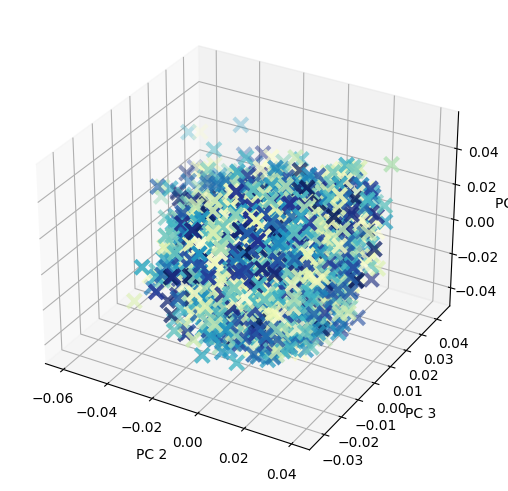

In [ ]:
## resnet 18


fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(3, 1, width_ratios=[1])#, height_ratios=[1, 2, 1])

ax6 = fig.add_subplot(gs[:3, 0], projection='3d')

#projections = projections[600:800, :]
x = np.arange(len(projections))

#ax6.plot(-projections[:, 1], projections[:,2],projections[:, 0], color="k", linewidth=3, alpha = 0.5, marker="x", markerfacecolor="#ccc")
ax6.scatter(-projections[:, 1], projections[:,2],projections[:, 0], c=x ,cmap="YlGnBu", linewidth=3, marker="x", s = 100)#, markerfacecolor="#ccc")

#ax6.scatter(-projections[:, 1][index], projections[:,2][index],projections[:, 0][index], color="r", linewidth=3, alpha = 0.5, marker="x")
#ax6.plot(-projections[:, 1][:100], projections[:,2][:100],projections[:, 0][:100], color="r", linewidth=3, alpha = 0.5, marker="x")

ax6.set_xlabel('PC 2')
ax6.set_ylabel('PC 3')
ax6.set_zlabel('PC 1')

ax6.view_init(elev=30)#, roll=15)

# Hide grid lines
ax6.grid(True)

# Hide axes ticks
#ax6.set_xticks([])
#ax6.set_yticks([])
#ax6.set_zticks([])

fig.tight_layout()
plt.savefig("pca.pdf", format = 'pdf')


# PC Alignment

In [ ]:
import scipy.io
import numpy as np
rh_fsaverage_x = scipy.io.loadmat(f'rh_x.mat')[f'x_rh']
rh_fsaverage_y = scipy.io.loadmat(f'rh_y.mat')[f'y_rh']
rh_fsaverage_ind = scipy.io.loadmat(f'rh_ind.mat')[f'ind_rh']
fsaverage_roi_patch1 = np.load(f'rh.all-vertices_fsaverage_space.npy')
fmri = np.load('rh_training_fmri.npy')
fmri.shape

temp_rh = np.zeros((len(fsaverage_roi_patch1),1))
temp_rh[rh_fsaverage_ind] = 1
temp_rh = temp_rh.reshape(len(temp_rh),)

X_val = np.full((len(fsaverage_roi_patch1),), np.nan)
Y_val = np.full((len(fsaverage_roi_patch1),), np.nan)

X_val[temp_rh == 1,] = rh_fsaverage_x.reshape(np.size(rh_fsaverage_x,axis=1),)
Y_val[temp_rh == 1,] = rh_fsaverage_y.reshape(np.size(rh_fsaverage_y,axis=1),)

rh_patch1_data_with_xy = np.full((len(fsaverage_roi_patch1),2), np.nan)# 0: data; 1: x value; 2: y_value
rh_patch1_data_with_xy[:,0] = X_val
rh_patch1_data_with_xy[:,1] = Y_val


valid_indices = np.where(fsaverage_roi_patch1 == 1)[0]

pos = rh_patch1_data_with_xy[valid_indices]

In [ ]:
fmri_T = np.swapaxes(fmri, 0, 1)
fmri_sorted_y = [f for f, _ in sorted(zip(fmri_T, pos), key=lambda x: x[1][1])]
pos_y = [p for _, p in sorted(zip(fmri_T, pos), key=lambda x: x[1][1])]
fmri_sorted = [f for f, _ in sorted(zip(fmri_sorted_y, pos_y), key=lambda x: x[1][0])]
pos_xy = [p for _, p in sorted(zip(fmri_sorted_y, pos_y), key=lambda x: x[1][0])]

all = np.asarray(fmri_sorted)
pos = np.asarray(pos)

In [ ]:
##brain pc
#.swapaxes(0, 1)
#all = normalize(all, axis=1)#[:, :10]

pca = PCA(n_components=10)
pca.fit(all[10000:11000])
projections = pca.transform(all[10000:11000])

brain_PC_all = pca.components_
print(np.sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)
brain_PC_all.shape

0.47310048
[0.11931594 0.09473489 0.0631384  0.04744698 0.03599115 0.02773085
 0.02451797 0.02298987 0.01995818 0.01727627]


(10, 8779)

In [ ]:
import pickle
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

with open('nsd_layer4_gaussian.pkl', 'rb') as f:
    IT_features = pickle.load(f) #(7901, 2116)

IT_features = IT_features.swapaxes(0, 1)
#IT_features = normalize(IT_features, axis=1)


pca = PCA(n_components=10)
pca.fit(IT_features)
projections = pca.transform(IT_features)
print(np.sum(pca.explained_variance_ratio_))
pca.explained_variance_ratio_

gaussian_PC_all = pca.components_

gaussian_PC_all.shape

0.97028744


(10, 7901)

In [ ]:
cos_matrix = []
for i in range(0, 10):
  max1 = []
  for j in range(0, 10):
    gaussian_PC = gaussian_PC_all[j, :100]# first 100 dim of pc
    #res_PC = res_PC_all[i, :]
    brain_PC = brain_PC_all[i, :100]

    cos_sim = dot(brain_PC, gaussian_PC)/(norm(brain_PC)*norm(gaussian_PC))
    #print(cos_sim)
    max1.append(cos_sim)
    cos_matrix.append(cos_sim)

  print(max(abs(np.array(max1))))

0.25270396
0.1977175
0.15259875
0.20807551
0.20174408
0.18230474
0.14076193
0.21132478
0.113745
0.1646227
